In [1]:
#this section contains all the commands that need to be run once at the begining of the script
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

path = r'C:\Users\sryan\Documents\CareerFoundry\Insta Cart Basket Analysis'

ords_prod = pd.read_pickle(os.path.join(path, '02 data', 'Prepared data', 'orders_products_flagged.pkl'))
cust = pd.read_csv(os.path.join(path, '02 data', 'Original data', 'customers.csv'))

# part 1 
# reviewing customer data set

In [9]:
cust.head()

,user_id,First Name,Surnam,Gender,STATE,Age,date_joined,n_dependants,fam_status,income
0,26711,Deborah,Esquivel,Female,Missouri,48,1/1/2017,3,married,165665
1,33890,Patricia,Hart,Female,New Mexico,36,1/1/2017,0,single,59285
2,65803,Kenneth,Farley,Male,Idaho,35,1/1/2017,2,married,99568
3,125935,Michelle,Hicks,Female,Iowa,40,1/1/2017,0,single,42049
4,130797,Ann,Gilmore,Female,Maryland,26,1/1/2017,1,married,40374


In [10]:
cust.shape

(206209, 10)

In [11]:
cust.describe()

,user_id,Age,n_dependants,income
count,206209.000000,206209.000000,206209.000000,206209.000000
mean,103105.000000,49.501646,1.499823,94632.852548
std,59527.555167,18.480962,1.118433,42473.786988
min,1.000000,18.000000,0.000000,25903.000000
25%,51553.000000,33.000000,0.000000,59874.000000
50%,103105.000000,49.000000,1.000000,93547.000000
75%,154657.000000,66.000000,3.000000,124244.000000
max,206209.000000,81.000000,3.000000,593901.000000


In [12]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206209 entries, 0 to 206208
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       206209 non-null  int64 
 1   First Name    194950 non-null  object
 2   Surnam        206209 non-null  object
 3   Gender        206209 non-null  object
 4   STATE         206209 non-null  object
 5   Age           206209 non-null  int64 
 6   date_joined   206209 non-null  object
 7   n_dependants  206209 non-null  int64 
 8   fam_status    206209 non-null  object
 9   income        206209 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 15.7+ MB


looking at this data I can see that first name has fewer non-null values than the other columns and could be the only column 
with missing data



In [13]:
cust.isnull().sum()

user_id             0
First Name      11259
Surnam              0
Gender              0
STATE               0
Age                 0
date_joined         0
n_dependants        0
fam_status          0
income              0
dtype: int64

the above code confirms that First Name is the only column with null values

These could have been entered by customer incorrectly.  before removing them I would want to check if those user ID's have made any purchases. though this should automatically happen when the data sets are joined.  after the join it would be worth reviewing the number of null first names.  if we wanted to clean this a good starting place would be to look for duplicates ignoring first name.  

In [14]:
#check for duplicate data
cust_dups = cust[cust.duplicated()]

In [ ]:
cust_dups.shape

There are no duplicte entries in this data.

In [16]:
mixed_col = []
for col in cust.columns.tolist():
  weird = (cust[[col]].applymap(type) != cust[[col]].iloc[0].apply(type)).any(axis = 1)
  if len (cust[weird]) > 0:
    print (col)


First Name


first name is the only mixed data type column.  this is probably due to the null values and would be fixed by removing the values or just casting the column to string

In [17]:
 ords_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32404859 entries, 0 to 32404858
Data columns (total 25 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int64   
 1   user_id                 int64   
 2   Cust_order_num          int64   
 3   orders_day_of_week      int64   
 4   order_hour_of_day       int64   
 5   days_since_prior_order  float64 
 6   product_id              int64   
 7   add_to_cart_order       int64   
 8   reordered               int64   
 9   Unnamed: 0              int64   
 10  product_name            object  
 11  aisle_id                int64   
 12  department_id           int64   
 13  prices                  float64 
 14  _merge                  category
 15  price_range_loc         object  
 16  busiest_day             object  
 17  busiest_days            object  
 18  hour_busyness           object  
 19  max_order               int64   
 20  loyalty_flag            object  
 21  mean_p

the user_id column would be a good key field to use to combine these tables both are int64 type

In [2]:
#dropping the _merge column.  it isn't needed for analysis and will cause issues when combining adational data.
ords_prod_clean = ords_prod.drop(columns = '_merge')

In [19]:
ords_prod_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32404859 entries, 0 to 32404858
Data columns (total 24 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   Cust_order_num          int64  
 3   orders_day_of_week      int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   product_id              int64  
 7   add_to_cart_order       int64  
 8   reordered               int64  
 9   Unnamed: 0              int64  
 10  product_name            object 
 11  aisle_id                int64  
 12  department_id           int64  
 13  prices                  float64
 14  price_range_loc         object 
 15  busiest_day             object 
 16  busiest_days            object 
 17  hour_busyness           object 
 18  max_order               int64  
 19  loyalty_flag            object 
 20  mean_price              float64
 21  spend_flag              objec

In [3]:
#merge the customer data with the rest of the data prevously combined
ords_prod_cust = ords_prod_clean.merge(cust, on = 'user_id', indicator = True)

In [21]:
ords_prod_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32404859 entries, 0 to 32404858
Data columns (total 34 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int64   
 1   user_id                 int64   
 2   Cust_order_num          int64   
 3   orders_day_of_week      int64   
 4   order_hour_of_day       int64   
 5   days_since_prior_order  float64 
 6   product_id              int64   
 7   add_to_cart_order       int64   
 8   reordered               int64   
 9   Unnamed: 0              int64   
 10  product_name            object  
 11  aisle_id                int64   
 12  department_id           int64   
 13  prices                  float64 
 14  price_range_loc         object  
 15  busiest_day             object  
 16  busiest_days            object  
 17  hour_busyness           object  
 18  max_order               int64   
 19  loyalty_flag            object  
 20  mean_price              float64 
 21  spend_

In [22]:
ords_prod_cust.isnull().sum()

order_id                        0
user_id                         0
Cust_order_num                  0
orders_day_of_week              0
order_hour_of_day               0
days_since_prior_order    2076096
product_id                      0
add_to_cart_order               0
reordered                       0
Unnamed: 0                      0
product_name                    0
aisle_id                        0
department_id                   0
prices                          0
price_range_loc                 0
busiest_day                     0
busiest_days                    0
hour_busyness                   0
max_order                       0
loyalty_flag                    0
mean_price                      0
spend_flag                      0
median_days_since_last          5
frequency_flag                  5
First Name                1775118
Surnam                          0
Gender                          0
STATE                           0
Age                             0
date_joined   

reviewing the new data set I see there are null values in both the days_since_prior_order and First Name fields.  we addressed the days_since_prior_order null values in a prior step so those are ok.  I want to take a little deeper look at the null first names though.

In [26]:
#create a data frame of all entries where the first name is null for review 
df_null_name = ords_prod_cust[ords_prod_cust['First Name'].isnull() == True]

In [35]:
df_null_name.head(50)

,order_id,user_id,Cust_order_num,orders_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,Unnamed: 0,...,First Name,Surnam,Gender,STATE,Age,date_joined,n_dependants,fam_status,income,_merge
1234,2759128,81,3,1,9,14.0,196,2,0,195,...,NaN,Sanchez,Male,Ohio,49,11/4/2017,1,married,123542,both
1235,1812985,81,5,2,20,30.0,196,1,1,195,...,NaN,Sanchez,Male,Ohio,49,11/4/2017,1,married,123542,both
1236,3097714,81,1,2,15,NaN,13176,1,0,13176,...,NaN,Sanchez,Male,Ohio,49,11/4/2017,1,married,123542,both
1237,2027712,81,4,3,19,30.0,13176,1,1,13176,...,NaN,Sanchez,Male,Ohio,49,11/4/2017,1,married,123542,both
1238,1928924,81,7,4,18,30.0,44683,4,0,44687,...,NaN,Sanchez,Male,Ohio,49,11/4/2017,1,married,123542,both
1239,2759128,81,3,1,9,14.0,14715,3,0,14715,...,NaN,Sanchez,Male,Ohio,49,11/4/2017,1,married,123542,both
1240,2027712,81,4,3,19,30.0,6184,2,0,6184,...,NaN,Sanchez,Male,Ohio,49,11/4/2017,1,married,123542,both
1241,1812985,81,5,2,20,30.0,6184,3,1,6184,...,NaN,Sanchez,Male,Ohio,49,11/4/2017,1,married,123542,both
1242,2759128,81,3,1,9,14.0,22362,4,0,22363,...,NaN,Sanchez,Male,Ohio,49,11/4/2017,1,married,123542,both
1243,1812985,81,5,2,20,30.0,12341,2,0,12341,...,NaN,Sanchez,Male,Ohio,49,11/4/2017,1,married,123542,both


In [33]:
df_null_name.describe()

,order_id,user_id,Cust_order_num,orders_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,Unnamed: 0,aisle_id,department_id,prices,max_order,mean_price,median_days_since_last,Age,n_dependants,income
count,1.775118e+06,1.775118e+06,1.775118e+06,1.775118e+06,1.775118e+06,1.661725e+06,1.775118e+06,1.775118e+06,1.775118e+06,1.775118e+06,1.775118e+06,1.775118e+06,1.775118e+06,1.775118e+06,1.775118e+06,1.775118e+06,1.775118e+06,1.775118e+06,1.775118e+06
mean,1.710813e+06,1.021960e+05,1.746052e+01,2.752456e+00,1.342349e+01,1.099288e+01,2.554399e+04,8.311160e+00,5.909523e-01,2.554570e+04,7.115305e+01,9.950525e+00,1.307483e+01,3.374394e+01,1.307483e+01,1.026979e+01,4.932357e+01,1.505062e+00,9.905700e+04
std,9.873846e+05,6.029603e+04,1.787233e+01,2.091833e+00,4.278136e+00,8.760145e+00,1.408458e+04,7.109144e+00,4.916582e-01,1.408613e+04,3.820942e+01,6.276553e+00,5.644408e+02,2.571365e+01,9.282801e+01,7.122230e+00,1.860522e+01,1.125715e+00,4.290017e+04
min,8.000000e+00,6.100000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,1.350000e+00,0.000000e+00,1.800000e+01,0.000000e+00,2.593700e+04
25%,8.558340e+05,4.865900e+04,5.000000e+00,1.000000e+00,1.000000e+01,5.000000e+00,1.350000e+04,3.000000e+00,0.000000e+00,1.350000e+04,3.100000e+01,4.000000e+00,4.200000e+00,1.300000e+01,7.371065e+00,6.000000e+00,3.300000e+01,0.000000e+00,6.585200e+04
50%,1.708741e+06,1.030650e+05,1.100000e+01,3.000000e+00,1.300000e+01,8.000000e+00,2.514600e+04,6.000000e+00,1.000000e+00,2.514700e+04,8.300000e+01,9.000000e+00,7.400000e+00,2.700000e+01,7.812069e+00,8.000000e+00,4.900000e+01,2.000000e+00,9.667900e+04
75%,2.568419e+06,1.545080e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01,3.788600e+04,1.100000e+01,1.000000e+00,3.789000e+04,1.070000e+02,1.600000e+01,1.120000e+01,4.800000e+01,8.258699e+00,1.300000e+01,6.500000e+01,3.000000e+00,1.273560e+05
max,3.421083e+06,2.062040e+05,9.900000e+01,6.000000e+00,2.300000e+01,3.000000e+01,4.968800e+04,1.000000e+02,1.000000e+00,4.969200e+04,1.340000e+02,2.100000e+01,9.999900e+04,9.900000e+01,1.072134e+04,3.000000e+01,8.100000e+01,3.000000e+00,5.924090e+05


upon initial inspection these look like legitimate entries and should stay in the data

In [41]:
ords_prod_cust_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32404859 entries, 0 to 32404858
Data columns (total 33 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int64   
 1   user_id                 int64   
 2   Cust_order_num          int64   
 3   orders_day_of_week      int64   
 4   order_hour_of_day       int64   
 5   days_since_prior_order  float64 
 6   product_id              int64   
 7   add_to_cart_order       int64   
 8   reordered               int64   
 9   product_name            object  
 10  aisle_id                int64   
 11  department_id           int64   
 12  prices                  float64 
 13  price_range_loc         object  
 14  busiest_day             object  
 15  busiest_days            object  
 16  hour_busyness           object  
 17  max_order               int64   
 18  loyalty_flag            object  
 19  mean_price              float64 
 20  spend_flag              object  
 21  median

In [ ]:
#dropping the _merge column again as it serves no use
ords_prod_cust_clean = ords_prod_cust.drop(columns = '_merge')

In [48]:
#frequency_flag is a bit ambigous so I'm going to give it a more descriptive name
ords_prod_cust_clean.rename(columns = {'frequency_flag' : 'purchase_frequency'}, inplace = True)

In [49]:
ords_prod_cust_clean.head()

,order_id,user_id,Cust_order_num,orders_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,Unnamed: 0,...,purchase_frequency,First Name,Surnam,Gender,STATE,Age,date_joined,n_dependants,fam_status,income
0,2539329,1,1,2,8,NaN,196,1,0,195,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423
1,2398795,1,2,3,7,15.0,196,1,1,195,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423
2,473747,1,3,3,12,21.0,196,1,1,195,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423
3,2254736,1,4,4,7,29.0,196,1,1,195,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423
4,431534,1,5,4,15,28.0,196,1,1,195,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423


In [50]:
#export data to pkl
ords_prod_cust_clean.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'orders_products_cust.pkl'))

# Part 2

the script above part 2 doesn't need to be run to work on part 2. I'm reimporting all needed files and libraries

In [1]:
#this section contains all the commands that need to be run once at the begining of the script
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

path = r'C:\Users\sryan\Documents\CareerFoundry\Insta Cart Basket Analysis'

ords_prod_cust = pd.read_pickle(os.path.join(path, '02 data', 'Prepared data', 'orders_products_cust.pkl'))

# Key question 1 distribution of orders by hour of the day

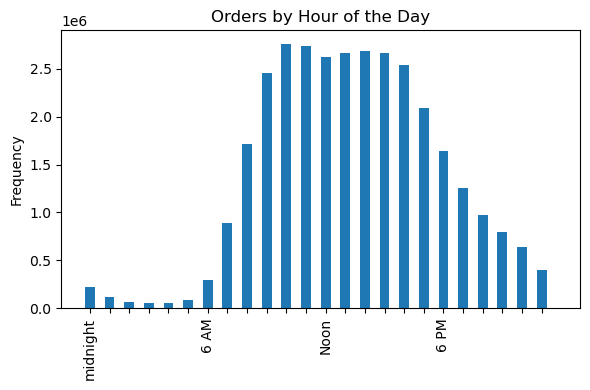

In [81]:
#create custom time labels and set their spacing
hours = ['midnight','','','','','','6 AM','','','','','','Noon','','','','','','6 PM','','','','','']
hours_pos = np.arange(24)

hist = ords_prod_cust['order_hour_of_day'].plot.hist(bins=24, figsize=(6,4), 
                                                     title='Orders by Hour of the Day',
                                                    range = (-.25,23.75),
                                                    width = .5)

plt.xticks(hours_pos, hours, rotation = 90)
plt.tight_layout()
plt.show()

In [82]:
#export the chart
hist.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'hist_ohod.png'))

# Key question 1 distribution of orders by day of the week

In [42]:
ords_prod_cust['orders_day_of_week'].describecribe()

count    3.240486e+07
mean     2.738867e+00
std      2.090077e+00
min      0.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      6.000000e+00
Name: orders_day_of_week, dtype: float64

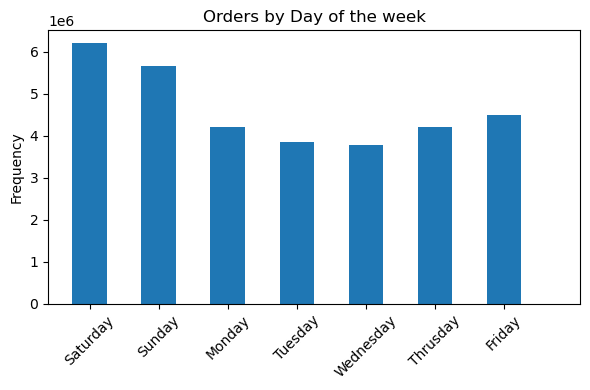

In [53]:
#Creates customer y axis labels and defines their position
y_labels = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thrusday','Friday']
y_pos = np.arange(len(x_labels))

hist_odow = ords_prod_cust['orders_day_of_week'].plot.hist(rot=45,
                                                      title='Orders by Day of the week',
                                                     range = (-.25,6.75),
                                                     bins = 7,
                                                     width = .5,
                                                     figsize=(6,4))

#plt.tick_params(labelbottom=False) removes labels from x axis
plt.xticks(y_pos, y_labels, rotation = 45)
plt.tight_layout()
plt.show()

In [54]:
#export the chart
hist_odow.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'hist_odow.png'))

Distribution showing customer loyalty

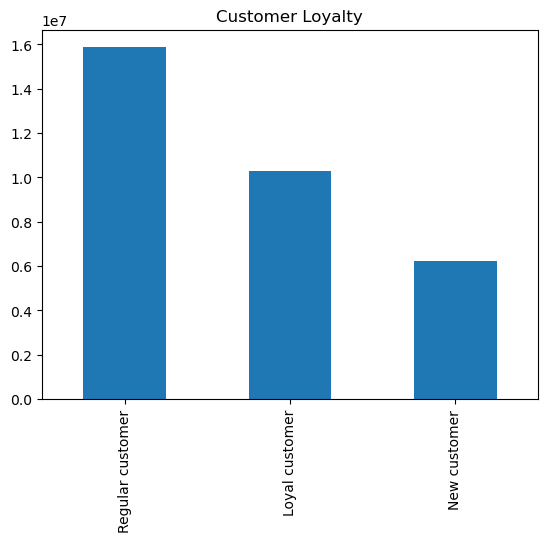

In [20]:
bar = ords_prod_cust['loyalty_flag'].value_counts().plot.bar(title='Customer Loyalty')

In [21]:
#export the chart
bar.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_loyalty.png'))

### exploring expenditure over different times of day will require a sample of the price data. The next several cells will create a representitive sample set of the data and explore the relationship.

In [22]:
#creates a random set of numbers 0-1 based on the length of the ords_prod_cust data frame
np.random.seed(4)
dev = np.random.rand(len(ords_prod_cust)) <= 0.7

#creates 2 new data frames 70% of the data is in the big 30% in the small.
big = ords_prod_cust[dev]
small = ords_prod_cust[~dev]

In [26]:
small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9721098 entries, 0 to 32404850
Data columns (total 33 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   Cust_order_num          int64  
 3   orders_day_of_week      int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   product_id              int64  
 7   add_to_cart_order       int64  
 8   reordered               int64  
 9   Unnamed: 0              int64  
 10  product_name            object 
 11  aisle_id                int64  
 12  department_id           int64  
 13  prices                  float64
 14  price_range_loc         object 
 15  busiest_day             object 
 16  busiest_days            object 
 17  hour_busyness           object 
 18  max_order               int64  
 19  loyalty_flag            object 
 20  mean_price              float64
 21  spend_flag              object

In [82]:
#create a data set of only the needed data for this analysis
df_2 = small[['prices', 'order_hour_of_day', 'fam_status', 'Age', 'n_dependants', 'income']]

In [40]:
df_2.describe()

,prices,order_hour_of_day,Age,n_dependants
count,9.721098e+06,9.721098e+06,9.721098e+06,9.721098e+06
mean,1.206026e+01,1.342589e+01,4.946128e+01,1.502105e+00
std,5.035394e+02,4.245184e+00,1.848547e+01,1.118703e+00
min,1.000000e+00,0.000000e+00,1.800000e+01,0.000000e+00
25%,4.200000e+00,1.000000e+01,3.300000e+01,1.000000e+00
50%,7.400000e+00,1.300000e+01,4.900000e+01,2.000000e+00
75%,1.130000e+01,1.600000e+01,6.500000e+01,3.000000e+00
max,9.999900e+04,2.300000e+01,8.100000e+01,3.000000e+00


In [42]:
df_2.loc[df_2['prices'] >100, 'prices'] = np.nan

In [43]:
df_2.describe()

,prices,order_hour_of_day,Age,n_dependants
count,9.719550e+06,9.721098e+06,9.721098e+06,9.721098e+06
mean,7.789179e+00,1.342589e+01,4.946128e+01,1.502105e+00
std,4.240952e+00,4.245184e+00,1.848547e+01,1.118703e+00
min,1.000000e+00,0.000000e+00,1.800000e+01,0.000000e+00
25%,4.200000e+00,1.000000e+01,3.300000e+01,1.000000e+00
50%,7.400000e+00,1.300000e+01,4.900000e+01,2.000000e+00
75%,1.130000e+01,1.600000e+01,6.500000e+01,3.000000e+00
max,2.500000e+01,2.300000e+01,8.100000e+01,3.000000e+00


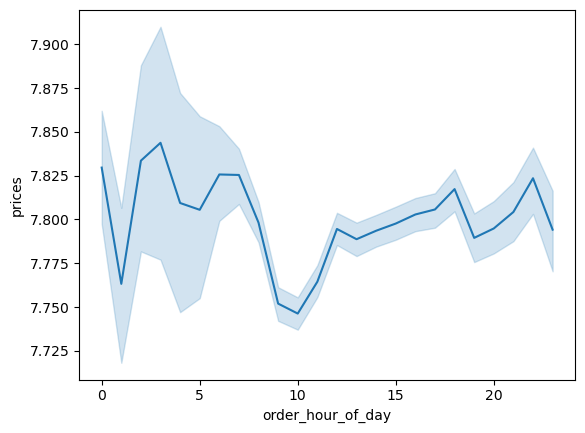

In [44]:
line = sns.lineplot(data = df_2, x = 'order_hour_of_day', y = 'prices')

In [30]:
#export the chart
line.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'line_expenditure.png'))

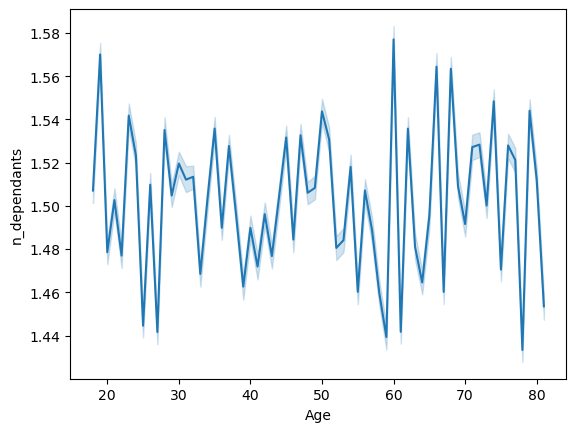

In [51]:
line_dem = sns.lineplot(data = df_2, x = 'Age', y = 'n_dependants')

the line chart shows the total number of dependants for each age group. I would expect the number of dependants to decrease as age increases, however, this chart doesn't do that.  in general I feel this chart isn't very useful.  I think a bar graph with the age groups grouped by number of dependants may be more informative.  

In [ ]:
#export the chart
line_dem.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'line_demographics.png'))

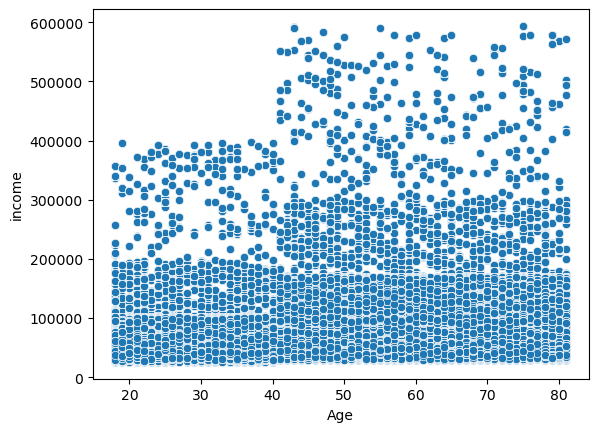

In [86]:
scat = sns.scatterplot(data = df_2, x = 'Age', y = 'income')

In [ ]:
#export the chart
scat.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'scatter_age_income.png'))

It looks like spending power goes up around 40.  there is a noticeable jump in income from around 400000 to around 600000 at that age.

### The below chart groups the ages into brackets to make the data a little more readable.  I grouped the data by age group and n_dependants then plotted the data in a bar graph.  I think this makes a more usable chart than the line chart made above. 

In [23]:
df_age_dep = ords_prod_cust[['Age', 'n_dependants']]

In [24]:
df_age_dep.describe()

,Age,n_dependants
count,3.240486e+07,3.240486e+07
mean,4.946527e+01,1.501896e+00
std,1.848558e+01,1.118865e+00
min,1.800000e+01,0.000000e+00
25%,3.300000e+01,1.000000e+00
50%,4.900000e+01,2.000000e+00
75%,6.500000e+01,3.000000e+00
max,8.100000e+01,3.000000e+00


In [78]:
df_age_dep.loc[df_age_dep['Age'] < 25, 'age group'] = '18-24'
df_age_dep.loc[(df_age_dep['Age'] >= 25) & (df_age_dep['Age'] < 35), 'age group'] = '25-34' 
df_age_dep.loc[(df_age_dep['Age'] >= 35) & (df_age_dep['Age'] < 45), 'age group'] = '35-44'
df_age_dep.loc[(df_age_dep['Age'] >= 45) & (df_age_dep['Age'] < 55), 'age group'] = '45-54'
df_age_dep.loc[(df_age_dep['Age'] >= 55) & (df_age_dep['Age'] < 65), 'age group'] = '55-64'
df_age_dep.loc[df_age_dep['Age'] >= 65, 'age group'] = '65+'

In [79]:
df_age_dep['age group'].value_counts()

65+      8575084
45-54    5111126
35-44    5062429
25-34    5054654
55-64    5028565
18-24    3573001
Name: age group, dtype: int64

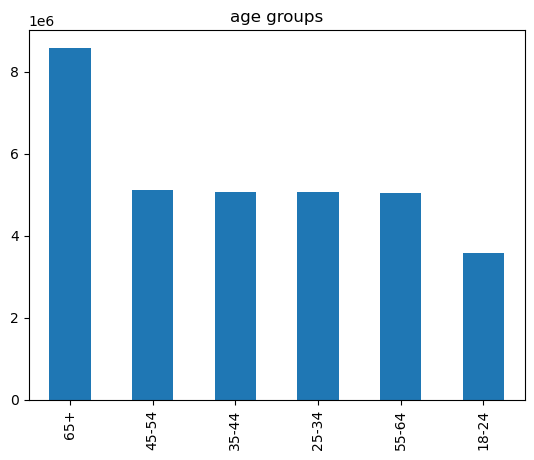

In [80]:
#bar chart showing age groups
bar = c

In [81]:
df_dem_group = df_age_dep.groupby(['age group', 'n_dependants'])['n_dependants'].count()

In [82]:
df_dem_group.head(6)

age group  n_dependants
18-24      0                863578
           1                922180
           2                877853
           3                909390
25-34      0               1293349
           1               1221502
Name: n_dependants, dtype: int64

<Axes: xlabel='age group,n_dependants'>

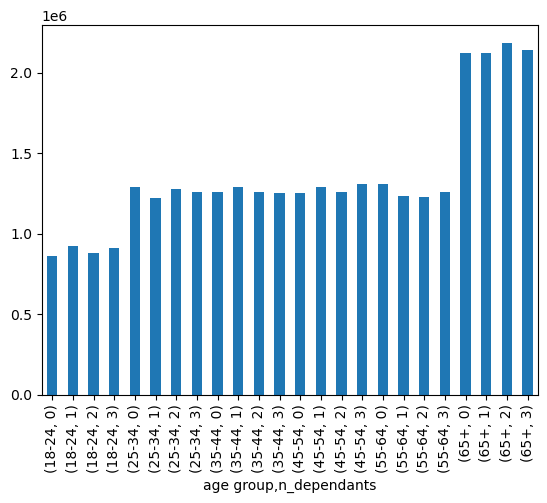

In [83]:
df_dem_group.plot(kind='bar')

I would have expected the number of dependants to decrease as the age group increased.  This chart doesn't show that. It may warrant further invistigation.